In [1]:
# Inicializar e importar Earth Engine
import ee

In [2]:
# Iniciar proceso de autenticación
ee.Authenticate()
# Inicializar la biblioteca
ee.Initialize(project="festive-bazaar-282413")

In [3]:
# Import the necessary libraries
import geemap
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from geemap import chart

In [6]:
#Use the code below to search for the forest reserve or protected area in your country of interest.
# Load the WDPA data
protected_areas = ee.FeatureCollection('WCMC/WDPA/current/polygons')
# Filter for protected areas in Zimbabwe
zimbabwe_protected_areas = protected_areas.filter(ee.Filter.eq('PARENT_ISO', 'COL'))
# Select the 'NAME' property of the features
names = zimbabwe_protected_areas.aggregate_array('NAME')
# Print the names of the protected areas
print(names.getInfo())

['Volcán Azufral Chaitan', 'Guásimo', 'La Nona', 'Alto del Nudo', 'La Marcada', 'Barbas  Bremen', 'Campoalegre', 'Ucumarí', 'Serranía de Minas', 'La Tatacoa', 'Serranía de Peñas Blancas', 'Serranía de Minas', 'Siberia Ceibas', 'Corredor Biológico Guácharos Puracé', 'Cerro Páramo de Miraflores Rigoberto Urriago', 'De la Cuenca Alta del Río  Quindío de Salento', 'Páramos y Bosques Altoandinos de Génova', 'Chili Bosque Alto Andino Pijao', 'Barbas Bremen', 'Bosque de Galilea', 'La Cima I Cima II y Altamira Maupaz', 'Corazon California la Palma  y Soledad Potosí', 'Bellavista', 'La Estrella la Cabaña Dulima', 'Esmeralda', 'La Suiza', 'El Toro', 'Vallecita', 'Las Mirlas', 'La Pradera', 'Cerrobravo', 'El Trebol', 'Las Damas', 'Uno', 'El Humedal y la Santísima Trinidad', 'Bremen Lote 16 y la Rinconada Lote 15', 'San Cristobal Alto de la Motañuela, San Cristobal Alto de la Matañuela II, el Porvenir, Esperanza y Buenos Aires', 'Puracé Porvenir las Violetas, Porvenir  I  Porvenir II', 'Olla Grand

In [14]:
# Define the boundary for Mafungabusi forest reserve
boundary = ee.FeatureCollection('WCMC/WDPA/current/polygons') \
.filter(ee.Filter.inList('NAME', ['Barbas Bremen']))

In [15]:
# Load Sentinel-2 spectral reflectance data.
s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
# Create a function to mask clouds using the Sentinel-2 QA band.
def maskS2clouds(image):
    qa = image.select('QA60')
    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = ee.Number(2).pow(10).int()
    cirrusBitMask = ee.Number(2).pow(11).int()
    # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(
        qa.bitwiseAnd(cirrusBitMask).eq(0))
    # Return the masked and scaled data.
    return image.updateMask(mask).divide(10000)

In [22]:
# Create a single composite image for a given period.
start_date = '2022-01-01'
end_date = '2025-10-31'

In [23]:
# Filter clouds from Sentinel-2 for the given period.
composite = s2.filterDate(start_date, end_date) \
.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30)) \
.map(maskS2clouds) \
.select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12']) # Select bands for display
# Compute the median composite and clip to the boundary.
S2_composite = composite.median().clip(boundary)

# Initialize our map before adding layers.
map1 = geemap.Map()
map1.centerObject(boundary, 12)

# Add the composite image to the map with specified display settings.
map1.addLayer(S2_composite, {'bands': ['B11', 'B8', 'B3'], 'min': 0, 'max': 0.3}, 'Sentinel-2 Composite')

In [24]:
# Display the map with layer control.
map1.addLayerControl()
map1

Map(center=[4.675827967763533, -75.62123613983776], controls=(WidgetControl(options=['position', 'transparent_…

In [25]:
# Calculate NDVI
ndvi = S2_composite.normalizedDifference(['B8', 'B4']).rename('NDVI')

In [26]:
# Calculate SAVI.
L = 0.5 # Soil adjustment factor, typically between 0 and 1
savi = S2_composite.expression(
'((NIR - Red) / (NIR + Red + L)) * (1 + L)', {
'NIR': S2_composite.select('B8'),
'Red': S2_composite.select('B4'),
'L': L
}).rename('SAVI')

In [28]:
# Calculate RESI
resi = S2_composite.expression(
    '((RE3 + RE2 - RE1) / (RE3 + RE2 + RE1))', {
'RE1': S2_composite.select('B5'),
'RE2': S2_composite.select('B6'),
'RE3': S2_composite.select('B7')
}).rename('RESI')
# Initialize our map.
map2 = geemap.Map()
map2.centerObject(boundary, 12)

In [29]:
# Add the NDVI and RESI layers to the map.
map2.addLayer(ndvi, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, 'NDVI')
map2.addLayer(savi, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, 'SAVI')
map2.addLayer(resi, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, 'RESI')
# Display the map with layer control.
map2.addLayerControl()
map2

Map(center=[4.675827967763533, -75.62123613983776], controls=(WidgetControl(options=['position', 'transparent_…

In [30]:
# Load SRTM DEM
SRTM = ee.Image("USGS/SRTMGL1_003")
# Clip Elevation to the boundary
elevation = SRTM.clip(boundary)
# Derive slope from the SRTM
slope = ee.Terrain.slope(SRTM).clip(boundary)
# Compute the minimum and maximum elevation values within the boundary.
min_elevation = elevation.reduceRegion(
reducer=ee.Reducer.min(),
geometry=boundary,
scale=30,
maxPixels=1e9
).get('elevation').getInfo()
max_elevation = elevation.reduceRegion(
reducer=ee.Reducer.max(),
geometry=boundary,
scale=30,
maxPixels=1e9
).get('elevation').getInfo()
print(f"Min Elevation: {min_elevation}, Max Elevation: {max_elevation}")

Min Elevation: 1487, Max Elevation: 2317


In [31]:
# Define attractive color gradients for elevation and slope
elevationPalette = ['006633', '99cc00', 'ffff00', 'ff9900', 'ff6600', 'ff3333', 'ff0000', 'cc0000',
'990000', '660000', '330000', '000000']
slopePalette = ['440154', '482878', '3E4A89', '31688E', '26838F', '1F9D8A', '6CCE59', 'B6DE2B',
'FDE724']
# Initialize your map.
map4 = geemap.Map()
map4.centerObject(boundary, 12)
# Add elevation layer to the map with new palette
vis_params_elevation = {'min': min_elevation, 'max': max_elevation, 'palette': elevationPalette}
map4.addLayer(elevation, vis_params_elevation, 'Elevation')
# Add slope layer to the map with new palette
vis_params_slope = {'min': 0, 'max': 60, 'palette': slopePalette}
map4.addLayer(slope, vis_params_slope, 'Slope')
# Display the map with layer control.
map4.addLayerControl()
map4

Map(center=[4.675827967763533, -75.62123613983776], controls=(WidgetControl(options=['position', 'transparent_…

In [32]:
# Merge the predictor variables
mergedCollection = (
S2_composite
.addBands(ndvi)
.addBands(savi)
.addBands(resi)
.addBands(elevation)
.addBands(slope)
)
# Clip the output image to the farm boundary
clippedmergedCollection = mergedCollection.clipToCollection(boundary)
# Bands to include in the regression
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12','NDVI', 'SAVI','RESI', 'elevation',
'slope']

In [34]:
# Define the date range
start_date = '2022-01-01'
end_date = '2025-10-31'
# Prepare the mask
def qualityMask(im):
    return im.updateMask(im.select('l4_quality_flag').eq(1)) \
        .updateMask(im.select('degrade_flag').eq(0))
# Load the GEDI Level 4A (L4A) dataset with date filtering
dataset = ee.ImageCollection('LARSE/GEDI/GEDI04_A_002_MONTHLY') \
    .filterDate(start_date, end_date) \
    .map(qualityMask) \
    .select('agbd') \
    .filterBounds(boundary)
# Clip the dataset to the boundary
clippedDataset = dataset.mosaic().clipToCollection(boundary)
# Create the display parameters
gediVis = {
    'min': 1,
    'max': 300,
    'palette': 'red, green, blue'
}

In [35]:
# Sample the training points (ta) from the dataset
samplePoints = clippedDataset.sample(
region=boundary,
scale=30,
geometries=True
)

In [36]:
# Get the AGDB values from the 'agbd' property of the filtered points
agbd_values = samplePoints.aggregate_array('agbd').getInfo()

In [37]:
# Calculate summary statistics
mean_agbd = np.mean(agbd_values)
median_agbd = np.median(agbd_values)
std_agbd = np.std(agbd_values)
min_agbd = np.min(agbd_values)
max_agbd = np.max(agbd_values)
# Print the summary statistics
print("Mean AGBD:", mean_agbd)
print("Median AGBD:", median_agbd)
print("Standard Deviation AGBD:", std_agbd)
print("Minimum AGBD:", min_agbd)
print("Maximum AGBD:", max_agbd)
# Print and display the training (ta) points derived from the GEDI L4B dataset
print(samplePoints.size().getInfo())
print(samplePoints.first().getInfo())

Mean AGBD: 66.45960261266309
Median AGBD: 28.097183227539062
Standard Deviation AGBD: 104.98499942073865
Minimum AGBD: 0.0
Maximum AGBD: 756.166259765625
211
{'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Point', 'coordinates': [-75.61977637530347, 4.627356775792274]}, 'id': '0', 'properties': {'agbd': 5.9316630363464355}}


In [39]:
# Display the GEDI L4A mean above-ground biomass (AGB) points and the derived training points
# Initialize the map
map5 = geemap.Map()
map5.centerObject(boundary, 12)
map5.addLayer(clippedDataset, gediVis, 'GEDI L4A Mean AGBD points')
map5.addLayer(samplePoints, {'color': '#808080'}, 'Mean AGBD training points')
# Display the map
display(map5)

The provided color (red, green, blue) is invalid. Using the default black color.
'#red, green, blue' is not in web format. Need 3 or 6 hex digit.


Map(center=[4.675827967763533, -75.62123613983776], controls=(WidgetControl(options=['position', 'transparent_…

In [41]:
# Select specific bands from the 'clippedmergedCollection'
trainingData = clippedmergedCollection.select(bands).sampleRegions(**{
'collection': samplePoints,
'properties': ['agbd'],
'scale': 30
})

In [42]:
# Split training data into training and testing sets
# Add a random column (named random) and specify the seed value for repeatability
split = 0.7
trainingSet = trainingData.randomColumn('random', 27)
training = trainingSet.filter(ee.Filter.lessThan('random', split))
testing = trainingSet.filter(ee.Filter.greaterThanOrEquals('random', split))
# Check training data set
print(training.size().getInfo())
print(training.first().getInfo())
# Check the size of the testing data
print(testing.size().getInfo())
print(testing.first().getInfo())

155
{'type': 'Feature', 'geometry': None, 'id': '1_0', 'properties': {'B11': 0.21565000712871552, 'B12': 0.0982000008225441, 'B2': 0.03849999979138374, 'B3': 0.05979999899864197, 'B4': 0.030799999833106995, 'B5': 0.09544999897480011, 'B6': 0.29455000162124634, 'B7': 0.37264999747276306, 'B8': 0.3755500018596649, 'NDVI': 0.8484065532684326, 'RESI': 0.7496885657310486, 'SAVI': 0.5705577338489687, 'agbd': 222.852417, 'elevation': 1753, 'random': 0.28778615786433226, 'slope': 35.91942596435547}}
56
{'type': 'Feature', 'geometry': None, 'id': '0_0', 'properties': {'B11': 0.22834999859333038, 'B12': 0.1387999951839447, 'B2': 0.05950000137090683, 'B3': 0.07935000211000443, 'B4': 0.06800000369548798, 'B5': 0.1216999962925911, 'B6': 0.2612999975681305, 'B7': 0.3084999918937683, 'B8': 0.29660001397132874, 'NDVI': 0.6269884705543518, 'RESI': 0.6480115652084351, 'SAVI': 0.39659959334618183, 'agbd': 5.9316630363464355, 'elevation': 1844, 'random': 0.8185944377670413, 'slope': 1.8603935241699219}}


In [44]:
# Set the initial RF model parameters
init_params = {"numberOfTrees":500, # the number of individual decision tree models
"variablesPerSplit":None, # the number of features to use per split
"minLeafPopulation":1, # smallest sample size possible per leaf
"bagFraction":0.5, # fraction of data to include for each individual tree model
"maxNodes":None, # max number of leafs/nodes per tree
"seed":27} # random seed for "random" choices like sampling. Setting this allows others to reproduce your exact results even with stocastic parameters
# Perform the random forest regression
rf_regressor = ee.Classifier.smileRandomForest(**init_params) \
.setOutputMode('REGRESSION') \
.train(**{
'features': training,
'classProperty': 'agbd',
'inputProperties': bands
})

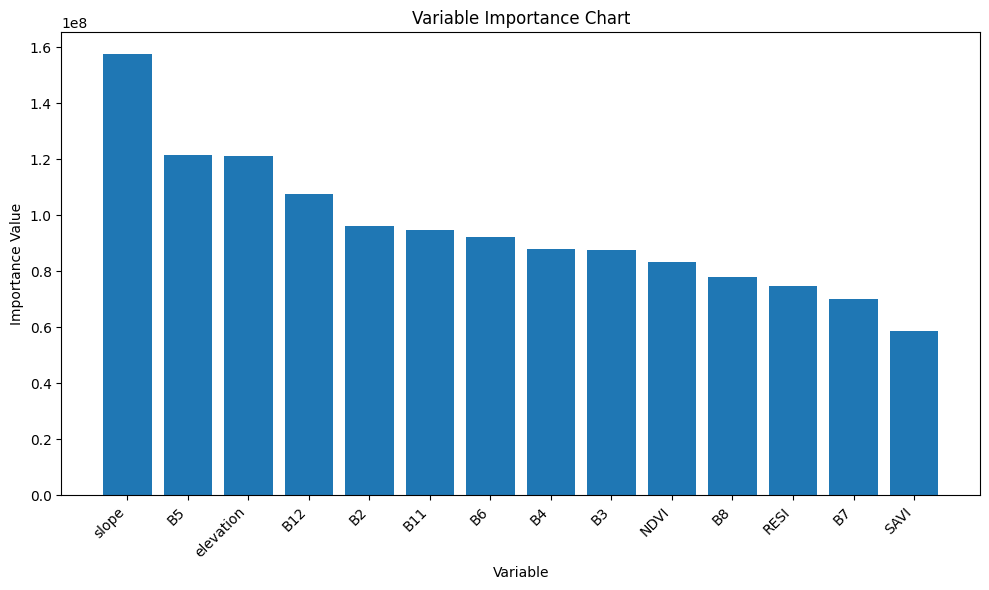

In [45]:
# Get details of classifier
regressor_details = rf_regressor.explain()
# Explain the classifier with importance values
variable_importance = ee.Dictionary(regressor_details).get('importance')
# Convert the variable importance dictionary to a list of tuples
variable_importance_list = variable_importance.getInfo().items()
# Sort the list by importance values
sorted_variable_importance = sorted(variable_importance_list, key=lambda x: x[1], reverse=True)
# Extract labels and values for the chart
labels = [item[0] for item in sorted_variable_importance]
values = [item[1] for item in sorted_variable_importance]
# Create a bar chart using matplotlib
plt.figure(figsize=(10, 6))
plt.bar(labels, values)
plt.xlabel('Variable')
plt.ylabel('Importance Value')
plt.title('Variable Importance Chart')
plt.xticks(rotation=45, ha='right')
# Display the chart
plt.tight_layout()
plt.show()

RMSE: 68.32126877345914
R²: 0.7318335735028457


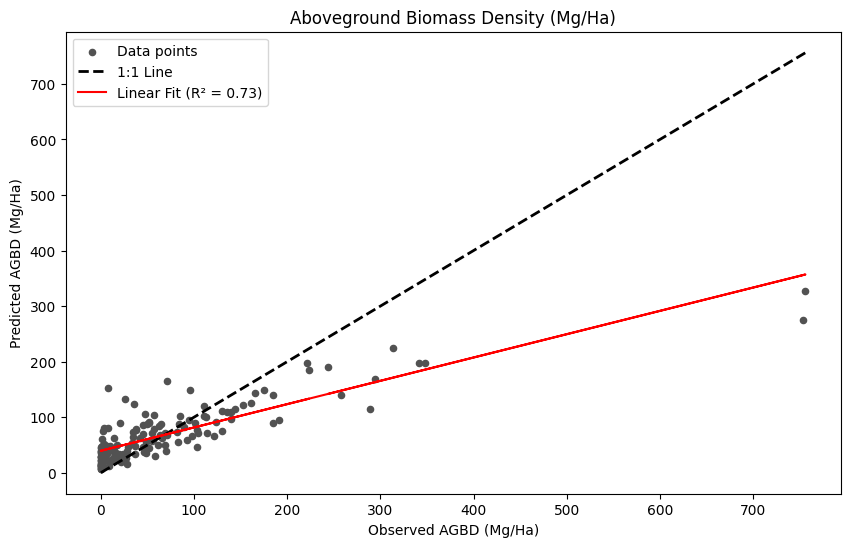

In [48]:
# Calculate RMSE
def calculate_rmse(input_fc):
    observed = ee.Array(input_fc.aggregate_array('agbd'))
    predicted = ee.Array(input_fc.aggregate_array('predicted'))
    rmse = observed.subtract(predicted).pow(2).reduce('mean', [0]).sqrt().get([0])
    return rmse
predicted_training = training.classify(rf_regressor, 'predicted')
rmse = calculate_rmse(predicted_training).getInfo()
print('RMSE:', rmse)
# Calculate R²
observed_values = np.array(predicted_training.aggregate_array('agbd').getInfo())
predicted_values = np.array(predicted_training.aggregate_array('predicted').getInfo())
r2 = np.corrcoef(observed_values, predicted_values)[0, 1] ** 2
print('R²:', r2)
# Create a plot of observed vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(observed_values, predicted_values, c='#525252', s=20, label='Data points')
plt.plot([observed_values.min(), observed_values.max()], [observed_values.min(),
observed_values.max()], 'k--', lw=2, label='1:1 Line')
# Linear fit
slope, intercept = np.polyfit(observed_values, predicted_values, 1)
plt.plot(observed_values, slope * observed_values + intercept, 'r', label=f'Linear Fit (R² = {r2:.2f})')
plt.xlabel('Observed AGBD (Mg/Ha)')
plt.ylabel('Predicted AGBD (Mg/Ha)')
plt.title('Aboveground Biomass Density (Mg/Ha)')
plt.legend()
plt.show()

Test RMSE: 81.38158266242351
Test R²: 0.2902881304139181


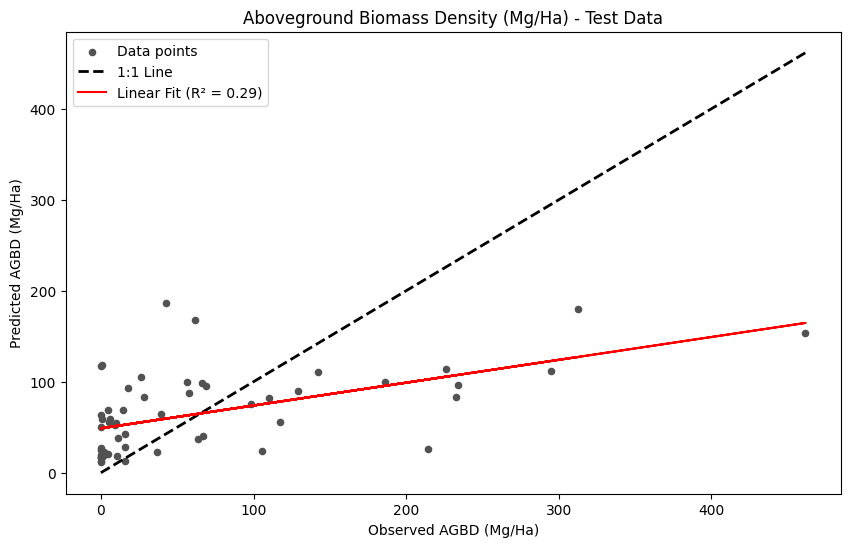

In [50]:
# Predict AGBD for the test data
predicted_testing = testing.classify(rf_regressor, 'predicted')
observed_testing_values = np.array(predicted_testing.aggregate_array('agbd').getInfo())
predicted_testing_values = np.array(predicted_testing.aggregate_array('predicted').getInfo())
# Calculate RMSE and R² for the validation data
rmse_testing = np.sqrt(mean_squared_error(observed_testing_values, predicted_testing_values))
r2_testing = r2_score(observed_testing_values, predicted_testing_values)
print('Test RMSE:', rmse_testing)
print('Test R²:', r2_testing)
# Create a plot of observed vs. predicted values for the test data
plt.figure(figsize=(10, 6))
plt.scatter(observed_testing_values, predicted_testing_values, c='#525252', s=20, label='Data points')
plt.plot([observed_testing_values.min(), observed_testing_values.max()],
[observed_testing_values.min(), observed_testing_values.max()], 'k--', lw=2, label='1:1 Line')
slope, intercept = np.polyfit(observed_testing_values, predicted_testing_values, 1)
plt.plot(observed_testing_values, slope * observed_testing_values + intercept, 'r', label=f'Linear Fit (R² = {r2_testing:.2f})')
plt.xlabel('Observed AGBD (Mg/Ha)')
plt.ylabel('Predicted AGBD (Mg/Ha)')
plt.title('Aboveground Biomass Density (Mg/Ha) - Test Data')
plt.legend()
plt.show()

In [51]:
# Predict AGBD
regression = clippedmergedCollection.select(bands).classify(rf_regressor, 'predicted').clip(boundary)
# Define a custom palette to display the AGBD map
palette = ['#FFFF00', '#ADFF2F', '#32CD32', '#2E8B57', '#006400']
# Prepare visualization parameters to display the AGBD regression on the map
viz = {
'min': 0,
'max': 120,
'palette': palette}
# Initialize the map
map6 = geemap.Map()
map6.centerObject(boundary, 12)
# Add visualization parameters
map6.addLayer(regression, viz, 'AGBD map')
map6.add_colorbar(viz, label="AGBD (Mg/ ha)", layer_name="AGBD map")
# Display the AGBD map
map6

Map(center=[4.675827967763533, -75.62123613983776], controls=(WidgetControl(options=['position', 'transparent_…